In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage.io import imread, imsave
from skimage.color import rgb2gray
%matplotlib inline 

In [3]:
# Load image by using scikit-image library

bricks_filename = 'bricks.jpg'
bricks_color = imread(bricks_filename)

(-0.5, 1079.5, 1439.5, -0.5)

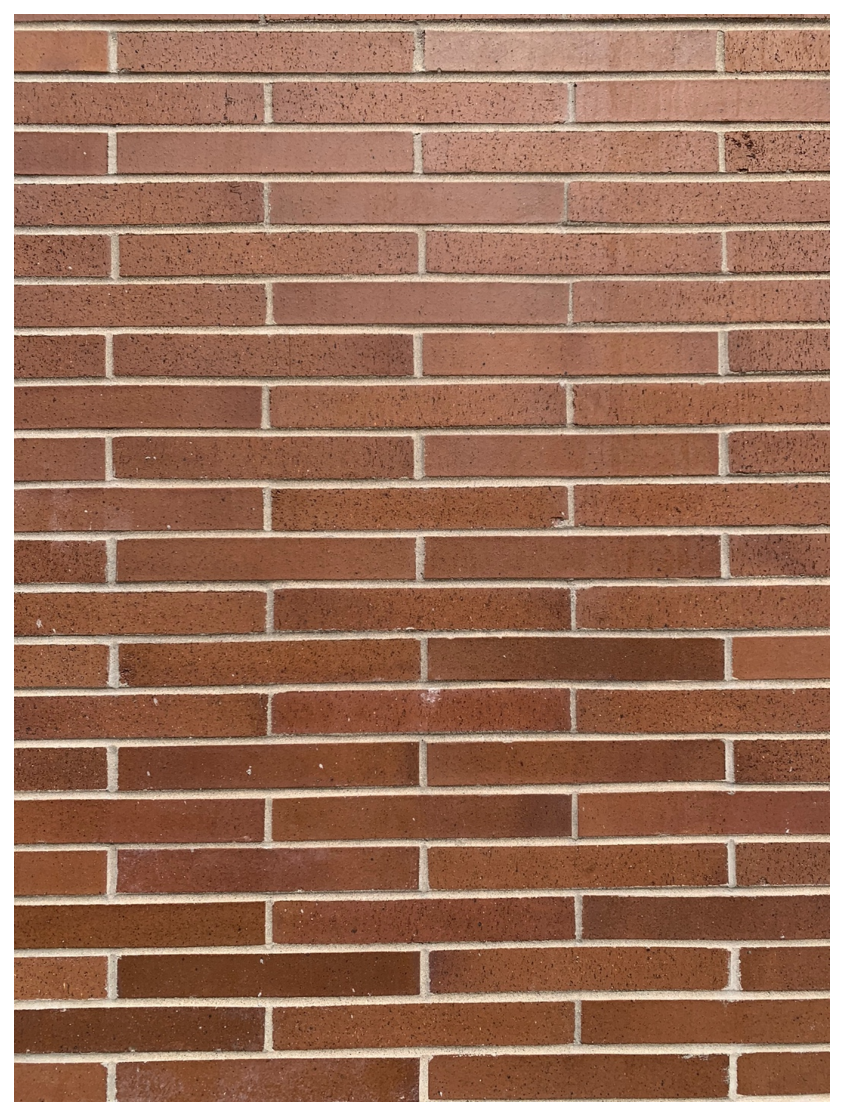

In [4]:
plt.figure(figsize = (10,10))
plt.imshow(bricks_color)
plt.axis('off')

In [5]:
bricks_color.shape

(1440, 1080, 3)

bricks\_color's type is np.ndarray and shaped 1440,1080, 3


We will first convert RGB scale to Gray scale, such that our image can be represented by a matrix. We will agin use the library skimage


In [6]:
bricks_gray = rgb2gray(bricks_color)

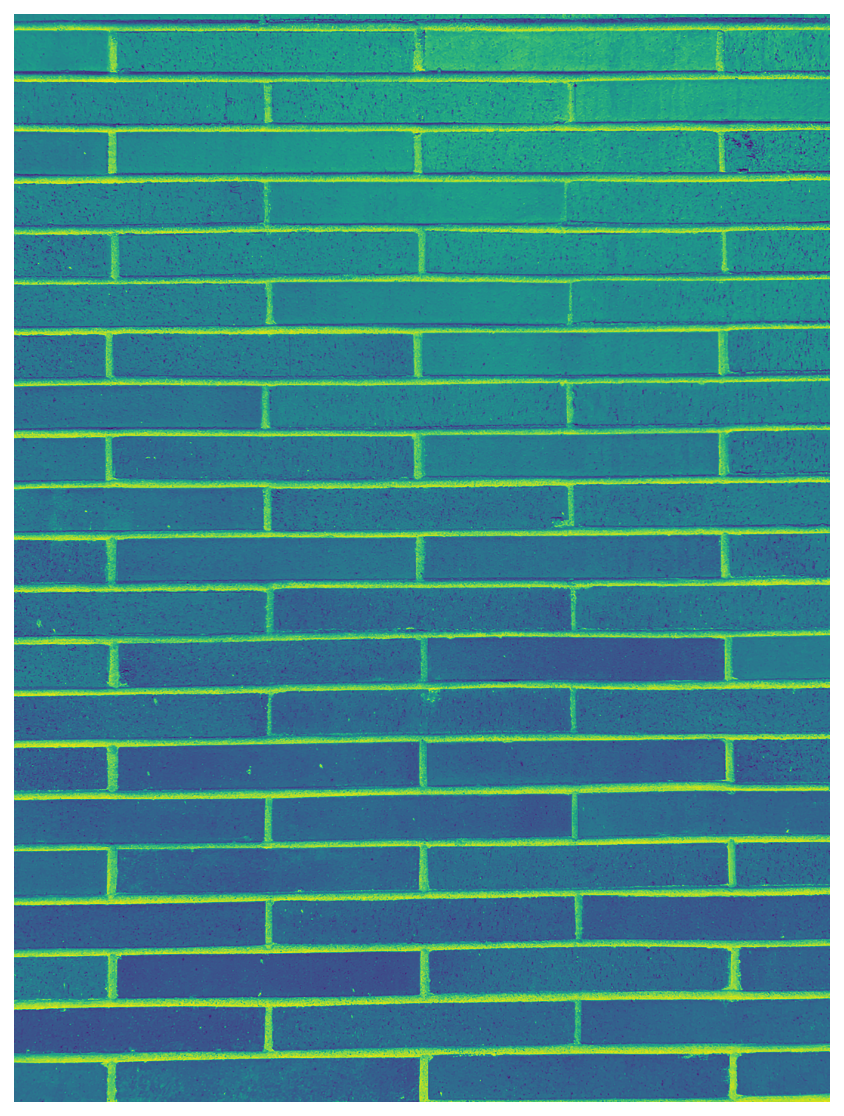

In [7]:
plt.figure(figsize = (10,10))
plt.imshow(bricks_gray)
_= plt.axis('off')

Since edge detection results are highly sensitive to image noise, we will apply Gaussian blur to get rid of the noise on the image.

To do so, image convolution technique is applied with a Gaussian Kernel \(3x3, 5x5\). The kernel size depends on the expected blurring effect. Basically, the smallest the kernel, the less visible is the blur. We will use a 5 by 5 Gaussian kernel



In [8]:
bricks_gray.shape

(1440, 1080)

In [9]:
def gaussian_kernel(size, sigma = 1):
    size = int(size)//2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1/(2.0 *np.pi*sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [10]:
gaussian_kernel(5)

array([[0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.02153928, 0.09653235, 0.15915494, 0.09653235, 0.02153928],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502]])

To get a same shape as input, we need to pad an image. Since we are using 5 x 5 kernel with stride 1, we pad an image with 2.



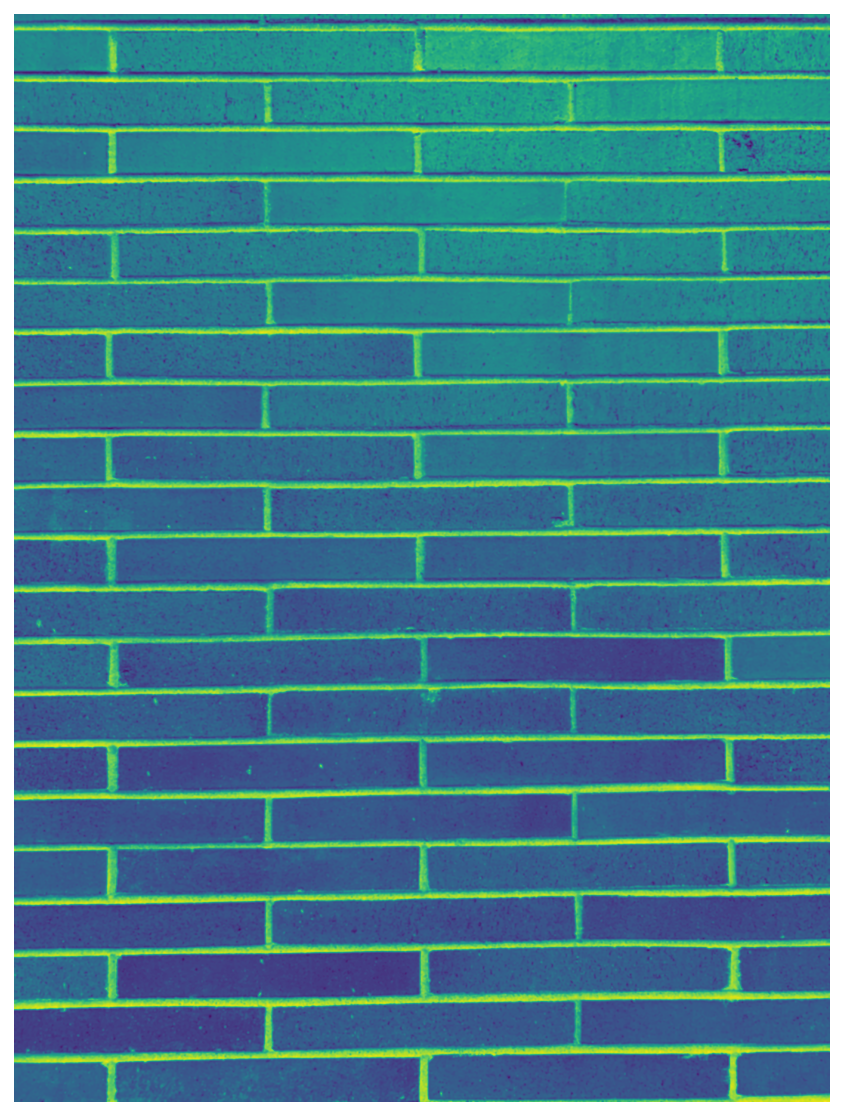

In [11]:
kernel = gaussian_kernel(5)

bricks_blur = ndi.convolve(bricks_gray, kernel)

plt.figure(figsize = (10,10))
plt.imshow(bricks_blur)
_=plt.axis('off')

In [12]:
bricks_blur.shape == bricks_gray.shape

True

The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators.

Edges correspond to a change of pixel's intensity. To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal \(x\) and vertical \(y\)

The Sobel filter is a  3 x 3 kernel that is applied to bricks\_gray. Since we want to compute the layers of bricks, we will use horizontal component for detecting edges in the horizontal direction.



In [13]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndi.convolve(img, Kx)
    Iy = ndi.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

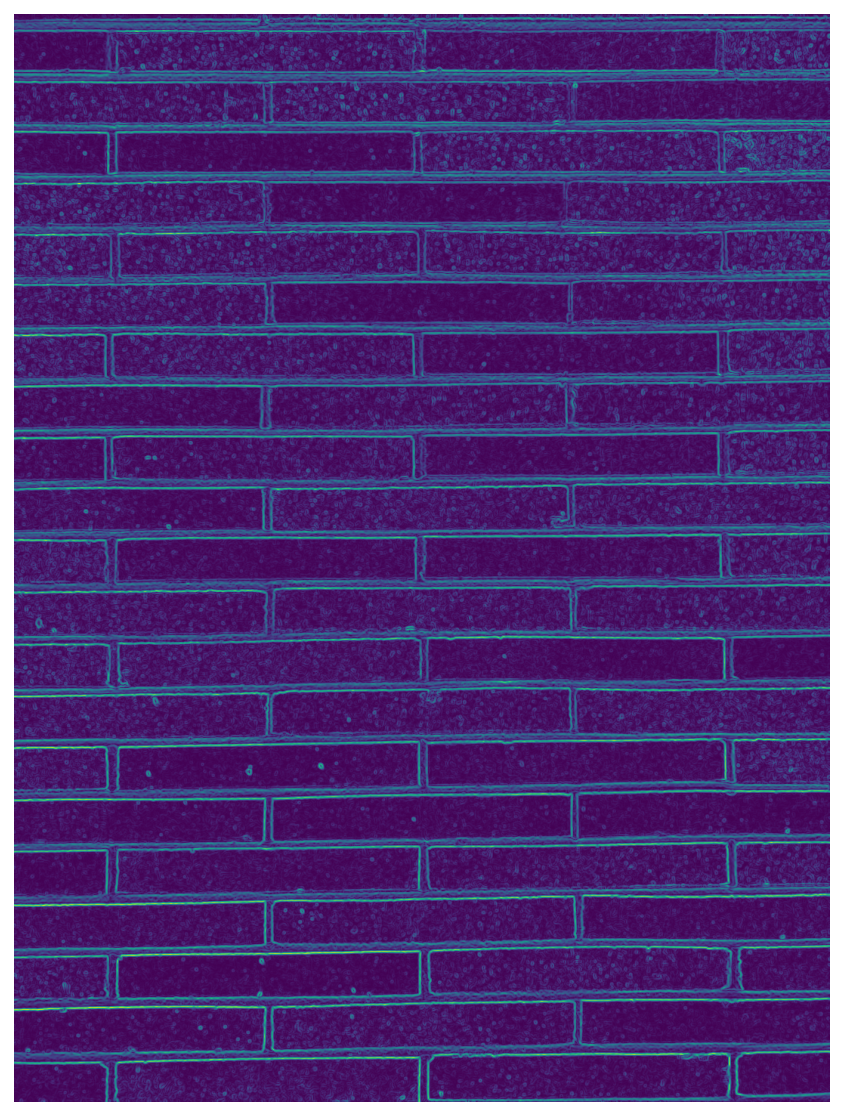

In [14]:
bricks_intensity, D = sobel_filters(bricks_blur)
plt.figure(figsize = (10,10))
plt.imshow(bricks_intensity)
_ = plt.axis('off')

In [15]:
bricks_intensity.shape == bricks_blur.shape

True

Ideally, the final image should have thin edges. Thus, we must perform non\-maximum suppression to thin out the edges.



In [16]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]

                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]


                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [17]:
bricks_nms = non_max_suppression(bricks_intensity, D)

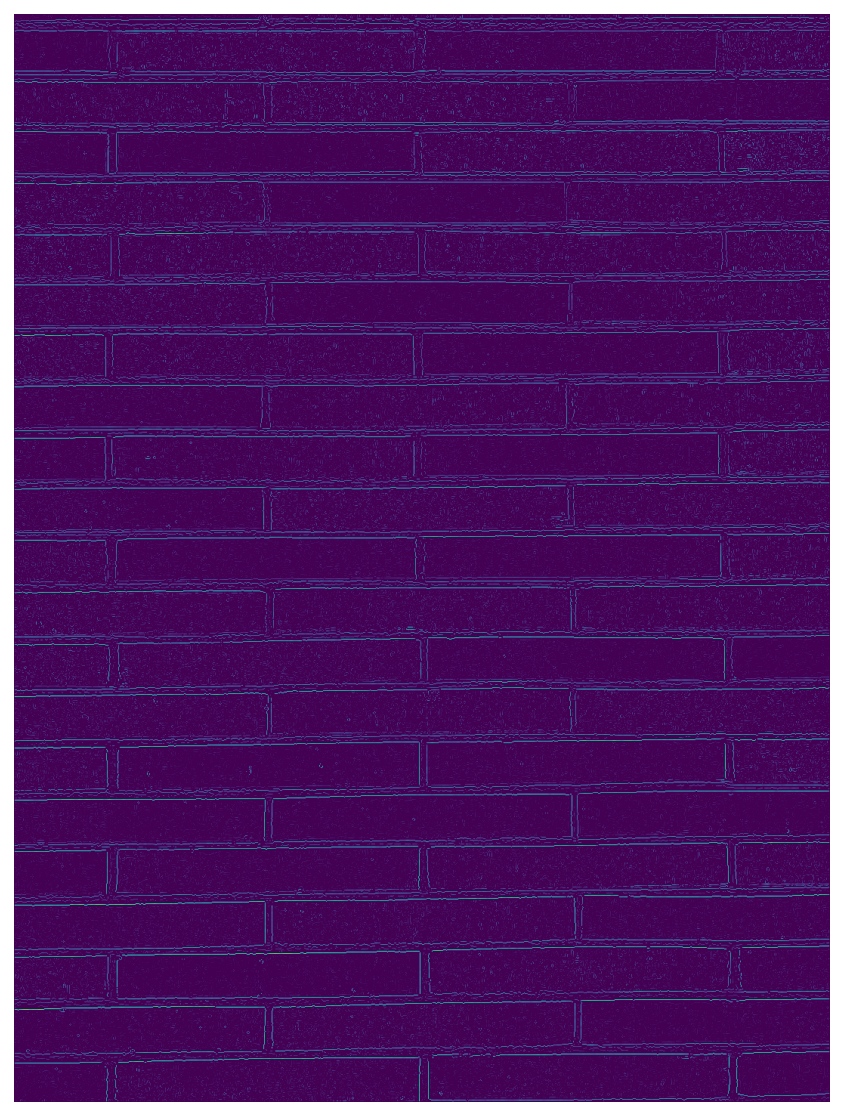

In [18]:
plt.figure(figsize = (10,10))
plt.imshow(bricks_nms)
_ = plt.axis('off')

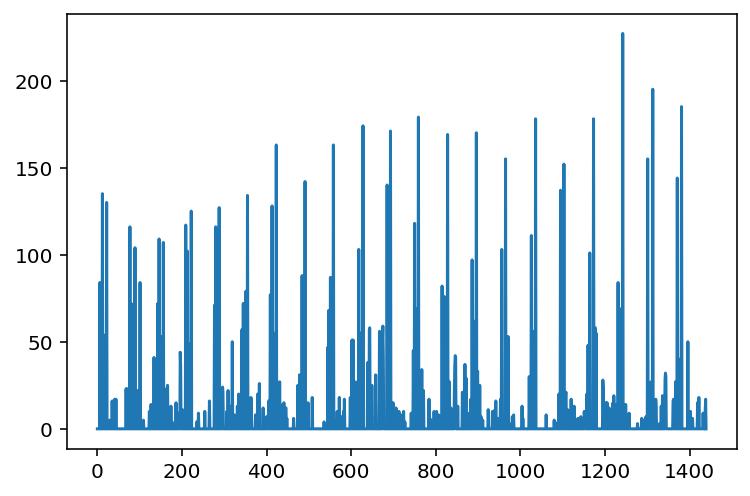

In [19]:
temp = bricks_nms[:, 400]
X = np.arange(len(temp))
plt.plot(X, temp)

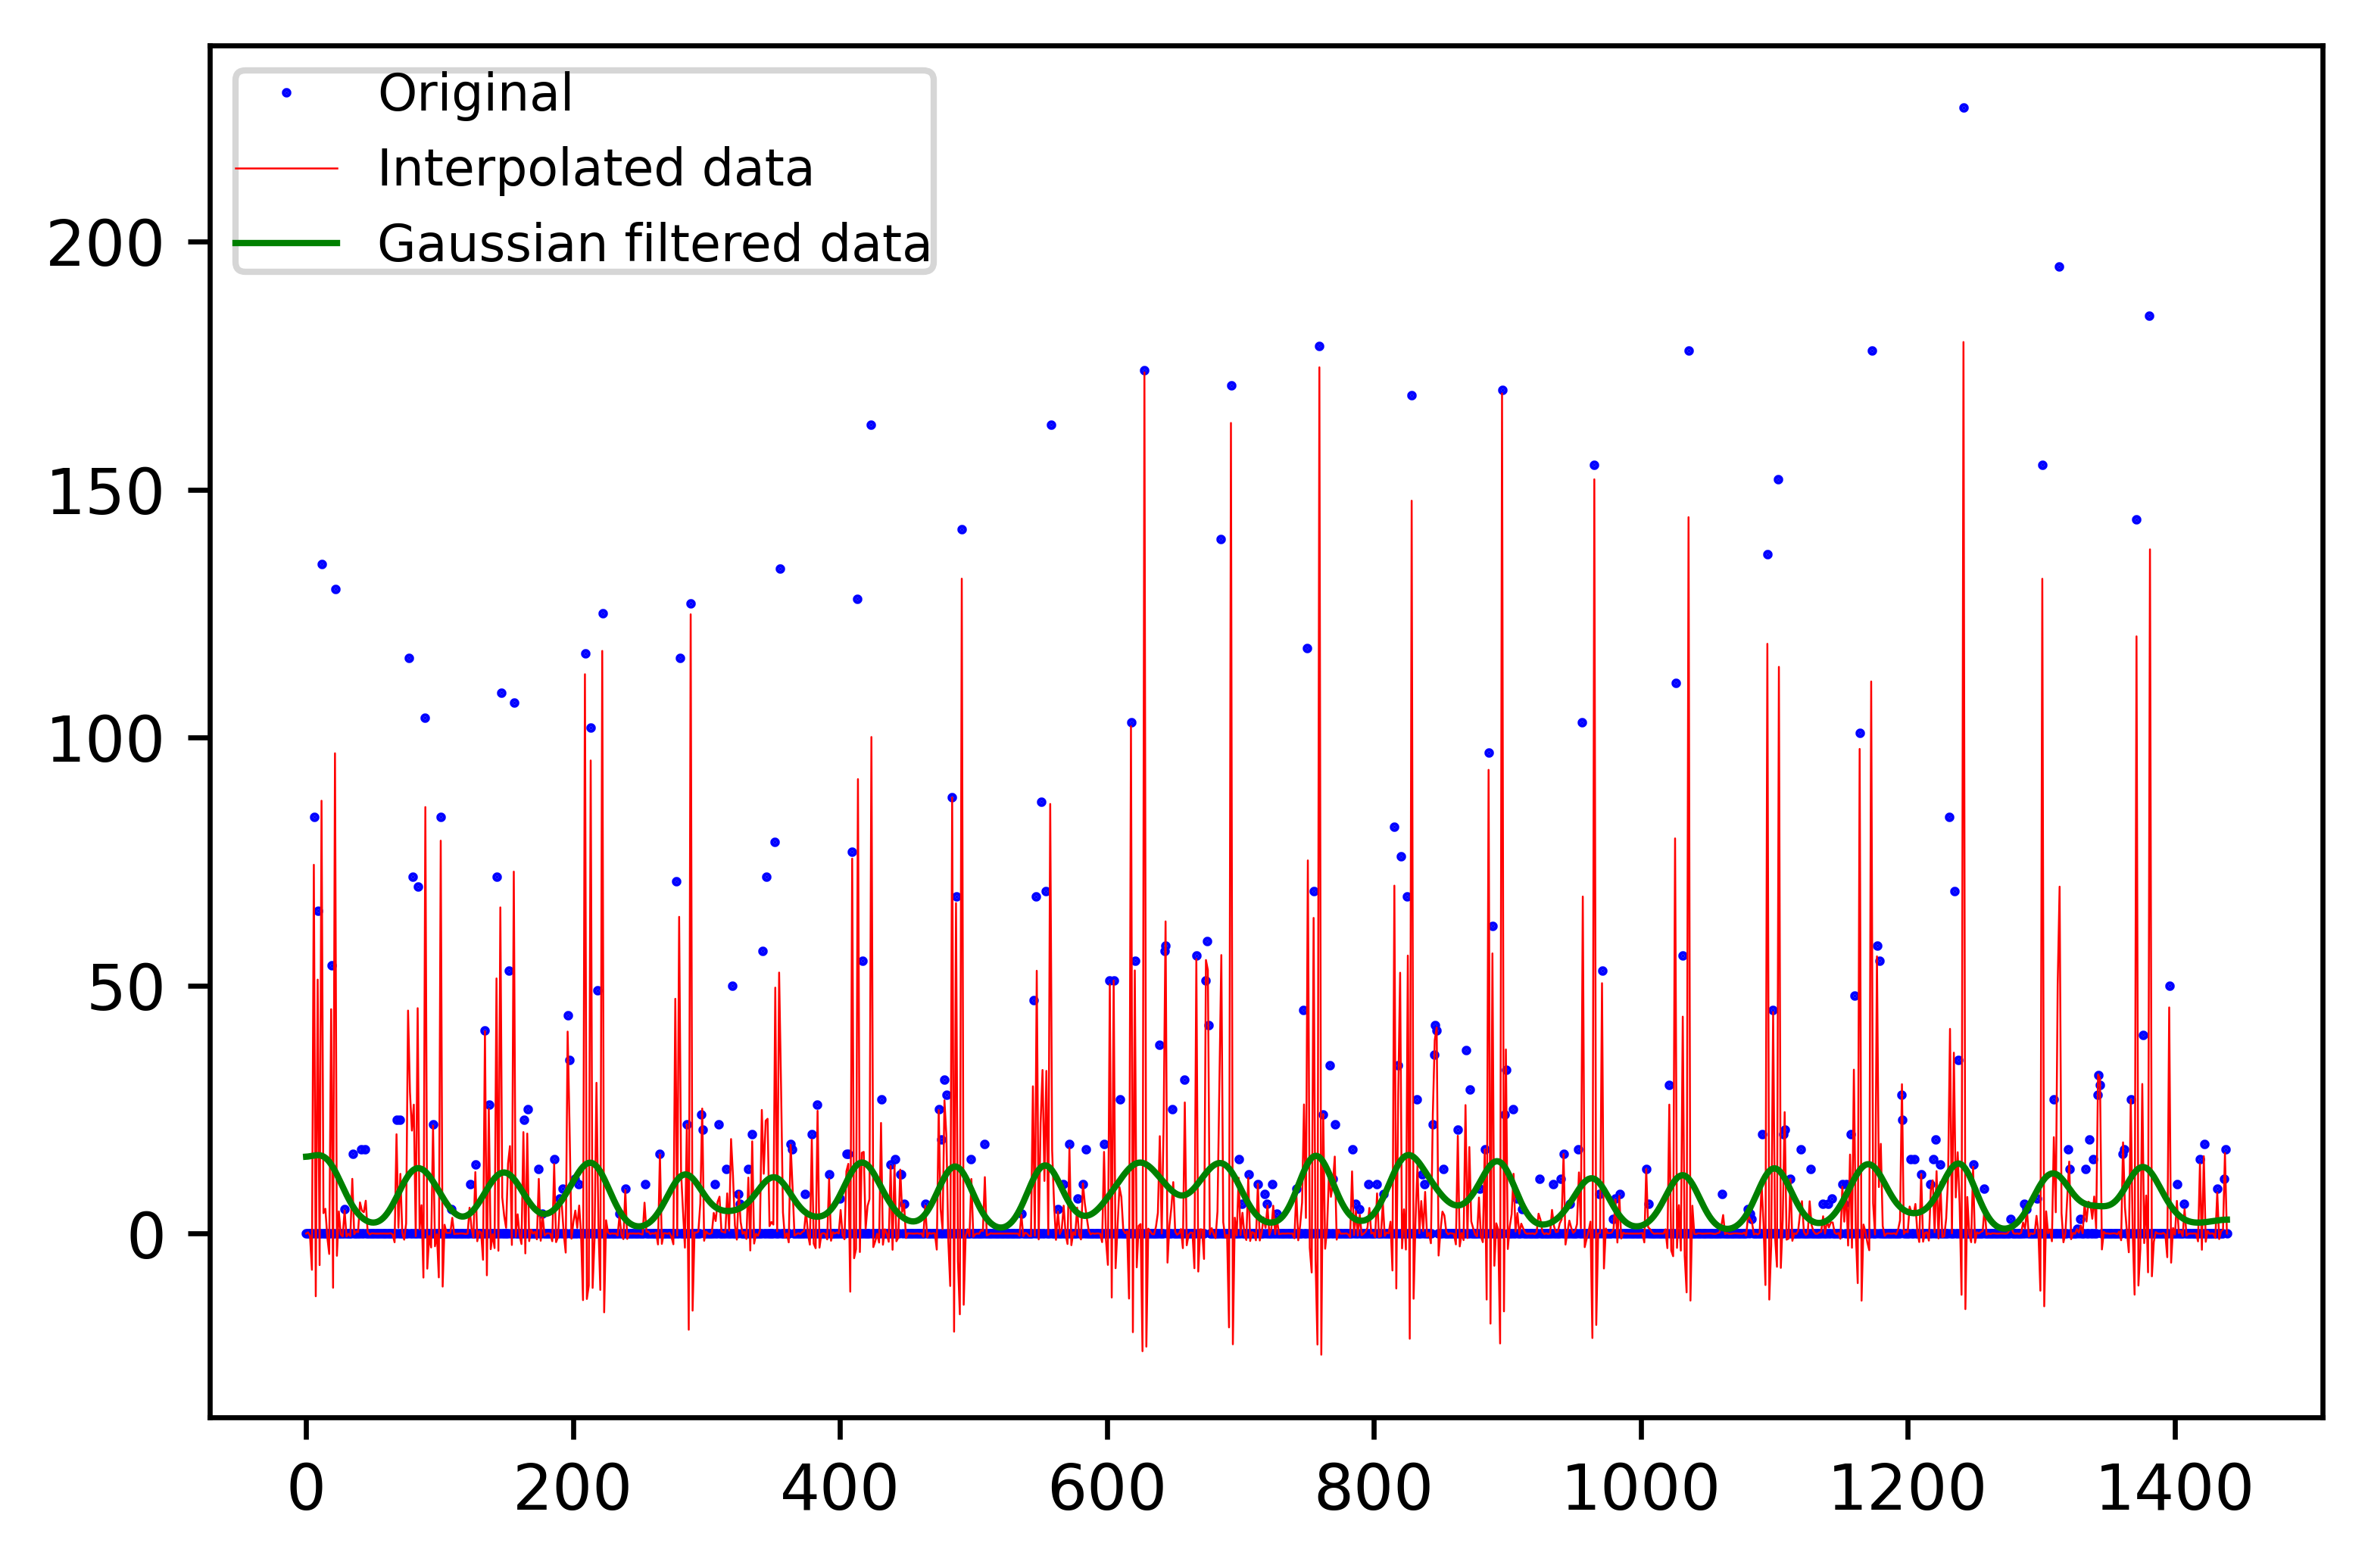

Number of bricks' layers: 21


In [20]:
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

spl = interpolate.UnivariateSpline(X, temp)

plt.figure(dpi = 300)
xs = np.linspace(X[0], X[-1], 1000)
plt.plot(X, temp, 'bo', markersize = 0.5, label = 'Original')
spl.set_smoothing_factor(1)
y = spl(xs)
y_smooth = gaussian_filter1d(y, sigma = 8)
peaks, _ = find_peaks(y_smooth)
plt.plot(xs, spl(xs), 'r-', lw=0.3, label = 'Interpolated data')
plt.plot(xs, y_smooth, 'g-', lw = 1, label = 'Gaussian filtered data')
plt.legend(fontsize = 8, borderpad=0.01)
plt.show()

print('''Number of bricks' layers:''', len(peaks))